# Adversarial Search: Playing "Mean" Connect 4


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it in any column. All disks above the removed disk will fall down one position. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

Inital State: An empty board <br>
Actions: Open columns, bottom of columns where an opponents piece has been placed.<br>
Transition Model: Place a friendly piece at the top of an open column, or remove an opponents piece from the bottom of a column, which shifts the rest of the column down, and place their piece in an open column. <br>
Test for Terminal State: Did a player place at least 4 pieces in a row (vertically, horizonally, or diagonally)? <br>
Utility for Terminal State: ?????????<br>

How big is the state space? Give an estimate and explain it.

Since there are 42 possible positions on a 7x6 board, and each position can be in 1 of 3 states (friend piece, enemy piece, no piece), the state space size would be slightly less than $3^{42} ≈ 1.094*10^{20}$ .<br><br>

The state space is less because there are rule constraints that prevent certain configurations from occuring; the game ends when at least one player has at least 4 consecutive pieces on the board. Therefore there can be a board with multiple sets of at least 4 consecutive, same-color pieces, if and only if there exists a common column where every set has at least 1 piece.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [3]:
# Your code/ answer goes here.

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [4]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

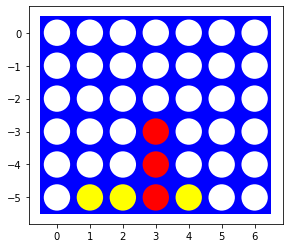

In [5]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

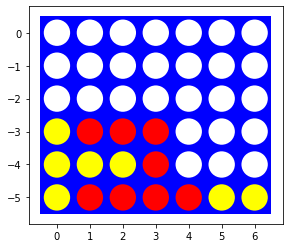

1


In [115]:
#help function to place a tile in a given row
def place_tile(board, col, player):
    row = -1
    #loop that finds the top of a column
    while(board[row][col]!= 0): row-=1
    board[row][col] = player


def mean_move(board, shift_col, add_col):
    add_player = board[-1][shift_col]
    row  = -1
    #loop moves up column until the current position has no pieces
    while(board[row][shift_col] != 0):
        #sets the top of the column to 0 if it is reached
        if(abs(row) == len(board)): board[row][shift_col]=0
        #replaces the piece in the current row with the piece in the row above it
        else:
            board[row][shift_col] = board[row-1][shift_col]
            row-=1
    #placing the removed tile in the desired row
    place_tile(board, add_col, add_player)

#transition model
# action: tuple(column to be shifted, column to be added) negative shift column denotes normal move
def execute_move(board, action, player):
    #places tile in desired column if a normal move is made
    if (action[0]<0): place_tile(board, action[1], player)
    #executes mean move
    else: mean_move(board, action[0], action[1])

#actions
#returns a list of all available moves for a given player
def get_actions(board, player):
    actions = []
    shiftable_cols = []

    #finding all the shiftable columns
    for index, col in enumerate(board[-1]):
        if col == -player: shiftable_cols.append(index)
    
    for index, col in enumerate(board[0]):
        if col == 0:
            #adds all normal moves to front of actions list
            actions[:0] = [(-1, index)]
            #adds all mean moves to back of actions list
            for shift in shiftable_cols:
                actions.append((shift, index))
        #adds mean moves where the column is full, and the bottom piece is placed back on top of the same column
        elif board[-1][index] == -player:
            actions.append((index, index))
    return actions



#terminal state
#def check_win(board, last_move, player):

#checking id there exists a vertical win
def check_vertical(board, last_move):
    row_placed = 0
    #finding location of most recently placed piece
    while board[row_placed][last_move[1]] == 0 : row_placed+=1

    #returning 0 if the most recent piece is at the top of a column that is shorter than 4
    if len(board) - row_placed < 4: return 0
    #returning 1 if the most recent piece and the 3 pieces below it add up to 4
    if(board[row_placed][last_move[1]] + board[row_placed+1][last_move[1]] + 
        board[row_placed+2][last_move[1]] + board[row_placed+3][last_move[1]] ==4): return 1
    #returning -1 if the most recent piece and the 3 pieces below it add up to -4
    if(board[row_placed][last_move[1]] + board[row_placed+1][last_move[1]] + 
        board[row_placed+2][last_move[1]] + board[row_placed+3][last_move[1]] == -4): return -1
    #returning 0 if the above conditions fail
    return 0

def check_horizontal(board, last_move, player):
    row_placed = 0
    row_shifted = 0
    opp_win = False

    #not executing if the last move was a shift and the tile was place in the same column
    if last_move[0] != last_move[1]:
        #finding location of most recently placed piece
        while board[row_placed][last_move[1]] == 0 : row_placed+=1
        #finding the left-most possible position of a row of 4 containing the previously placed piece
        left_pos = (last_move[1]-3, 0)[last_move[1]<3]

        #looping though all possible horizontal rows of 4 containing the previously placed piece
        while(left_pos+3 < len(board[0]) and left_pos <= last_move[1]):
            if board[row_placed][left_pos:left_pos+4] == 4*[player]: return player
            elif board[row_placed][left_pos:left_pos+4] == 4*[-player]: opp_win = True
            left_pos+=1

    #checking if most recent move was a shift move
    if last_move[0] >= 0:

        #finding top of most recently shifted column
        while board[row_shifted][last_move[0]] == 0 : row_shifted+=1

        for row in range(row_shifted, len(board)):
            #finding the left-most possible position of a row of 4 containing the previouly placed piece
            left_pos = (last_move[0]-3, 0)[last_move[0]<3]

            #looping though all possible horizontal rows of 4 containing the previously placed piece
            while(left_pos+3 < len(board[0]) and left_pos <= last_move[0]):
                if board[row][left_pos:left_pos+4] == 4*[player]: return player
                elif board[row][left_pos:left_pos+4] == 4*[-player]: opp_win = True
                left_pos+=1
    #returning 0 if no horizonal rows were found, returning -1 if the opponent achieved a horizonal row and the player didn't
    return(0,-player)[opp_win]






board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [-1, 1, 1, 1, 0, 0, 0],
         [-1, -1, -1, 1, 0, 0, 0],
         [-1,1,1, 1,1, -1, -1]]

visualize(board)
print(check_horizontal(board, (0,4), -1))


Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on bt yhe environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [7]:
# Your code/ answer goes here.

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [8]:
# Your code/ answer goes here.

## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting.

Implement the search starting from a given board and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [9]:
# Your code/ answer goes here.

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [10]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [11]:
# Your code/ answer goes here.

### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [12]:
# Your code/ answer goes here.

### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

In [13]:
# Your code/ answer goes here.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [14]:
# Your code/ answer goes here.

## Task 4: Heuristic Alpha-Beta Tree Search [3 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [15]:
# Your code/ answer goes here.

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [16]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

In [17]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [18]:
# Your code/ answer goes here.

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [19]:
# Your code/ answer goes here.

## Tournament task [+ 1 to 5 bonus point will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above. 

In [20]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move for a standard board ($6 \times 7$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [21]:
# Your code/ answer goes here.